# Project: Soccer Data Analysis
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Soccer dataset
This analysis dataset contains information about matches and players in European Soccer Leagues between 2008 and 2016.
The database is available in the following [link](https://www.kaggle.com/datasets/hugomathien/soccer).
It includes information on more than 25,000 matches and 10,000 players in 11 European Countries' lead championship. It also includes data on Players and Teams' attributes from the EA Sports FIFA video game series.

In [1]:
# Import libraries used in the project
import numpy as np 
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Questions to explore
Using this dataset we can explore specific characteristics about the league's, team's and player's statistics. We will try to answer the following questions:
* Which league has the highest average number of goals per match?
* Is there a home team advantage? In other words, do teams that play at home win more games?
* Which players improved their overall rating the most during the period?
* Is there a correlation between a player's height and his overall rating?
* Do players with a specific preferred foot have a higher overall rating?
* Which team attributes are associated with more victories?

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
#Creating the connection to the dataset
database = '/Users/caiopriszculnik/Documents/Python notebooks/Data Analyst Nanodegree/Project 2/database.sqlite'

In [3]:
con = sqlite3.connect(database)

In [4]:
#Looking at the table names
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", con)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


### Goals by country and season DataFrame
> We will create a table with the average number of goals per country league and season to investigate which country league has the highest average number of goals per season

In [5]:
#Selecting the average number of goals by country and season
goals_country = pd.read_sql("""SELECT
                                ct.name AS country_name,
                                lg.name AS league_name,
                                season,
                                AVG(home_team_goal) as average_home_team_goal,
                                AVG(away_team_goal) as average_away_team_goal
                                FROM Match mt
                                LEFT JOIN Country ct ON mt.country_id = ct.id
                                LEFT JOIN League lg ON mt.league_id = lg.id
                                GROUP BY 1, 2, 3;""", con)

goals_country.head()

,country_name,league_name,season,average_home_team_goal,average_away_team_goal
0,Belgium,Belgium Jupiler League,2008/2009,1.630719,1.163399
1,Belgium,Belgium Jupiler League,2009/2010,1.466667,1.223810
2,Belgium,Belgium Jupiler League,2010/2011,1.591667,1.054167
3,Belgium,Belgium Jupiler League,2011/2012,1.754167,1.125000
4,Belgium,Belgium Jupiler League,2012/2013,1.562500,1.366667


In [6]:
#create total goals column
goals_country['average_total_goals'] = goals_country['average_home_team_goal'] + goals_country['average_away_team_goal']

In [7]:
#Exploring the dataframe shape, info and data types
goals_country.shape

(88, 6)

In [8]:
goals_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country_name            88 non-null     object 
 1   league_name             88 non-null     object 
 2   season                  88 non-null     object 
 3   average_home_team_goal  88 non-null     float64
 4   average_away_team_goal  88 non-null     float64
 5   average_total_goals     88 non-null     float64
dtypes: float64(3), object(3)
memory usage: 4.2+ KB


In [9]:
goals_country.dtypes

country_name               object
league_name                object
season                     object
average_home_team_goal    float64
average_away_team_goal    float64
average_total_goals       float64
dtype: object

In [10]:
#Checking if there are any nulls in the dataframe
goals_country.isnull().sum()

country_name              0
league_name               0
season                    0
average_home_team_goal    0
average_away_team_goal    0
average_total_goals       0
dtype: int64

In [11]:
#Checking if there are any duplicated rows
goals_country.duplicated().sum()

0

Exploring the DataFrame it seems that it doesn't have any null columns and the data types of the columns are the expected ones. Therefore, we won't need to do any further data cleaning for this dataframe

### Match results DataFrame
> We will create a table that shows the number of goals for each match, the id of the winner team and a column that states the match result (Home team win, Away team win or Draw). This dataframe will be used to measure if there is a home team advantage.

In [12]:
#Selecting the matchs results with the winner team id and the match result
match_result = pd.read_sql("""SELECT
                                ct.name AS country_name,
                                lg.name AS league_name,
                                season,
                                date,
                                home_team_goal,
                                away_team_goal,
                                CASE 
                                    WHEN home_team_goal > away_team_goal THEN home_team_api_id
                                    WHEN home_team_goal < away_team_goal THEN away_team_api_id END AS winner_team_api_id,
                                CASE 
                                    WHEN home_team_goal > away_team_goal THEN "Home Team Win"
                                    WHEN home_team_goal < away_team_goal THEN "Away Team Win"
                                    ELSE "Draw" END AS match_result
                               FROM Match mt
                               LEFT JOIN Country ct ON mt.country_id = ct.id
                               LEFT JOIN League lg ON mt.league_id = lg.id""", con)

match_result.head()

,country_name,league_name,season,date,home_team_goal,away_team_goal,winner_team_api_id,match_result
0,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,1,1,NaN,Draw
1,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,0,0,NaN,Draw
2,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,0,3,8635.0,Away Team Win
3,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,5,0,9991.0,Home Team Win
4,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,1,3,9985.0,Away Team Win


In [13]:
#Exploring shape of the match_result
match_result.shape

(25979, 8)

In [14]:
#Exploring the number of nulls for each column
match_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_name        25979 non-null  object 
 1   league_name         25979 non-null  object 
 2   season              25979 non-null  object 
 3   date                25979 non-null  object 
 4   home_team_goal      25979 non-null  int64  
 5   away_team_goal      25979 non-null  int64  
 6   winner_team_api_id  19383 non-null  float64
 7   match_result        25979 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.6+ MB


In [15]:
match_result.isnull().sum()

country_name             0
league_name              0
season                   0
date                     0
home_team_goal           0
away_team_goal           0
winner_team_api_id    6596
match_result             0
dtype: int64

The only column with null values in this DataFrame is the winner_team_api_id which makes sense since matches that ended in a Draw don't have a winner. We don't need to do any aditional data cleaning for this DataFrame.

In [16]:
#Checking the columns data types
match_result.dtypes

country_name           object
league_name            object
season                 object
date                   object
home_team_goal          int64
away_team_goal          int64
winner_team_api_id    float64
match_result           object
dtype: object

### Wins and rating by team DataFrame
> We will create a table that shows the number of wins for each team in each season and its average ratings. This dataframe will be used to see if teams with better ratings win more games.

In [17]:
#Selecting the number of wins by team per season
match_wins_by_team = pd.read_sql("""WITH prep_match_winners AS (
                               SELECT
                                ct.name AS country_name,
                                lg.name AS league_name,
                                season,
                                date,
                                CASE 
                                    WHEN home_team_goal > away_team_goal THEN home_team_api_id
                                    WHEN home_team_goal < away_team_goal THEN away_team_api_id END AS winner_team_api_id
                               FROM Match mt
                               LEFT JOIN Country ct ON mt.country_id = ct.id
                               LEFT JOIN League lg ON mt.league_id = lg.id)
                               SELECT 
                                winner_team_api_id,
                                team_long_name,
                                league_name,
                                season,
                                COUNT(winner_team_api_id)AS wins_by_season
                               FROM prep_match_winners pmw
                               LEFT JOIN Team tm ON tm.team_api_id = pmw.winner_team_api_id
                               WHERE winner_team_api_id IS NOT NULL
                               GROUP BY 1, 2, 3, 4""", con)

match_wins_by_team.head()

,winner_team_api_id,team_long_name,league_name,season,wins_by_season
0,1601,Ruch Chorzów,Poland Ekstraklasa,2008/2009,9
1,1601,Ruch Chorzów,Poland Ekstraklasa,2009/2010,16
2,1601,Ruch Chorzów,Poland Ekstraklasa,2010/2011,10
3,1601,Ruch Chorzów,Poland Ekstraklasa,2011/2012,16
4,1601,Ruch Chorzów,Poland Ekstraklasa,2012/2013,8


In [18]:
#Selecting the average ratings by team and season
avg_team_attributes = pd.read_sql("""SELECT 
                                     ta.team_api_id,
                                     team_long_name,
                                     season,
                                     AVG(buildUpPlaySpeed) AS avg_speed,
                                     AVG(buildUpPlayDribbling) AS avg_dribbling,
                                     AVG(buildUpPlayPassing) AS avg_passing,
                                     AVG(chanceCreationPassing) AS avg_creation_passing,
                                     AVG(chanceCreationCrossing) AS avg_creation_crossing,
                                     AVG(chanceCreationShooting) AS avg_creation_shooting,
                                     AVG(defencePressure) AS avg_defence_pressure,
                                     AVG(defenceAggression) AS avg_defence_aggression  
                                     FROM Team_Attributes ta
                                     LEFT JOIN Match mt USING(date)
                                     LEFT JOIN Team tm USING(team_api_id)
                                     GROUP BY 1, 2, 3
                                     ORDER BY 2""", con)

avg_team_attributes.head()

,team_api_id,team_long_name,season,avg_speed,avg_dribbling,avg_passing,avg_creation_passing,avg_creation_crossing,avg_creation_shooting,avg_defence_pressure,avg_defence_aggression
0,8350,1. FC Kaiserslautern,None,49.0,54.0,52.0,49.0,54.0,64.0,41.0,51.0
1,8350,1. FC Kaiserslautern,2009/2010,45.0,NaN,55.0,45.0,70.0,70.0,70.0,70.0
2,8350,1. FC Kaiserslautern,2010/2011,48.0,NaN,42.0,49.0,68.0,53.0,38.0,48.0
3,8350,1. FC Kaiserslautern,2011/2012,38.0,NaN,54.0,43.0,49.0,64.0,37.0,51.0
4,8350,1. FC Kaiserslautern,2013/2014,61.0,NaN,54.0,43.0,62.0,56.0,48.0,50.0


In [19]:
#Exploring the team attributes shape, info and data types
avg_team_attributes.shape

(1457, 11)

In [20]:
avg_team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   team_api_id             1457 non-null   int64  
 1   team_long_name          1457 non-null   object 
 2   season                  1213 non-null   object 
 3   avg_speed               1457 non-null   float64
 4   avg_dribbling           488 non-null    float64
 5   avg_passing             1457 non-null   float64
 6   avg_creation_passing    1457 non-null   float64
 7   avg_creation_crossing   1457 non-null   float64
 8   avg_creation_shooting   1457 non-null   float64
 9   avg_defence_pressure    1457 non-null   float64
 10  avg_defence_aggression  1457 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 125.3+ KB


In [21]:
avg_team_attributes.dtypes

team_api_id                 int64
team_long_name             object
season                     object
avg_speed                 float64
avg_dribbling             float64
avg_passing               float64
avg_creation_passing      float64
avg_creation_crossing     float64
avg_creation_shooting     float64
avg_defence_pressure      float64
avg_defence_aggression    float64
dtype: object

In [22]:
#Merging team attributes and victories by team
df_team_wins_and_attributes = match_wins_by_team.merge(avg_team_attributes, left_on=['winner_team_api_id', 'team_long_name', 'season'],
                                                      right_on=['team_api_id', 'team_long_name','season'])
df_team_wins_and_attributes.head()

,winner_team_api_id,team_long_name,league_name,season,wins_by_season,team_api_id,avg_speed,avg_dribbling,avg_passing,avg_creation_passing,avg_creation_crossing,avg_creation_shooting,avg_defence_pressure,avg_defence_aggression
0,1601,Ruch Chorzów,Poland Ekstraklasa,2009/2010,16,1601,30.0,NaN,40.0,50.0,35.0,70.0,65.0,60.0
1,1601,Ruch Chorzów,Poland Ekstraklasa,2010/2011,10,1601,48.0,NaN,51.0,68.0,67.0,51.0,46.0,48.0
2,1601,Ruch Chorzów,Poland Ekstraklasa,2011/2012,16,1601,53.0,NaN,55.0,44.0,65.0,50.0,43.0,44.0
3,1601,Ruch Chorzów,Poland Ekstraklasa,2013/2014,14,1601,53.0,NaN,55.0,44.0,65.0,50.0,43.0,44.0
4,1601,Ruch Chorzów,Poland Ekstraklasa,2014/2015,8,1601,53.0,48.0,38.0,66.0,65.0,50.0,43.0,44.0


In [23]:
#Exploring the new dataframe shape
df_team_wins_and_attributes.shape

(892, 14)

In [24]:
#Exploring if the new dataframe has null values
df_team_wins_and_attributes.isnull().sum()

winner_team_api_id          0
team_long_name              0
league_name                 0
season                      0
wins_by_season              0
team_api_id                 0
avg_speed                   0
avg_dribbling             718
avg_passing                 0
avg_creation_passing        0
avg_creation_crossing       0
avg_creation_shooting       0
avg_defence_pressure        0
avg_defence_aggression      0
dtype: int64

In [25]:
df_team_wins_and_attributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892 entries, 0 to 891
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   winner_team_api_id      892 non-null    int64  
 1   team_long_name          892 non-null    object 
 2   league_name             892 non-null    object 
 3   season                  892 non-null    object 
 4   wins_by_season          892 non-null    int64  
 5   team_api_id             892 non-null    int64  
 6   avg_speed               892 non-null    float64
 7   avg_dribbling           174 non-null    float64
 8   avg_passing             892 non-null    float64
 9   avg_creation_passing    892 non-null    float64
 10  avg_creation_crossing   892 non-null    float64
 11  avg_creation_shooting   892 non-null    float64
 12  avg_defence_pressure    892 non-null    float64
 13  avg_defence_aggression  892 non-null    float64
dtypes: float64(8), int64(3), object(3)
memory 

As the average dribbling has a lot of null values we will drop this column and won't use it in our analysis

In [26]:
#Dropping the avg dribbling column
df_team_wins_and_attributes.drop('avg_dribbling', axis=1, inplace=True)
df_team_wins_and_attributes.head()

,winner_team_api_id,team_long_name,league_name,season,wins_by_season,team_api_id,avg_speed,avg_passing,avg_creation_passing,avg_creation_crossing,avg_creation_shooting,avg_defence_pressure,avg_defence_aggression
0,1601,Ruch Chorzów,Poland Ekstraklasa,2009/2010,16,1601,30.0,40.0,50.0,35.0,70.0,65.0,60.0
1,1601,Ruch Chorzów,Poland Ekstraklasa,2010/2011,10,1601,48.0,51.0,68.0,67.0,51.0,46.0,48.0
2,1601,Ruch Chorzów,Poland Ekstraklasa,2011/2012,16,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0
3,1601,Ruch Chorzów,Poland Ekstraklasa,2013/2014,14,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0
4,1601,Ruch Chorzów,Poland Ekstraklasa,2014/2015,8,1601,53.0,38.0,66.0,65.0,50.0,43.0,44.0


### Players attributes DataFrame
> We will create a table that shows the players attributes and his first and last overall ratings. This dataframe will be used to see which players improved the most during the period and if players with specific characteristics have a better overall rating.

In [27]:
#Selecting the players information and which overall rating it is in time
player = pd.read_sql("""SELECT 
                        pa.player_fifa_api_id,
                        pa.player_api_id,
                        date,
                        overall_rating,
                        preferred_foot,
                        attacking_work_rate,
                        player_name,
                        height,
                        weight,
                        ROW_NUMBER() OVER (PARTITION BY player_api_id ORDER BY date ASC) AS player_row_number_asc,
                        ROW_NUMBER() OVER (PARTITION BY player_api_id ORDER BY date DESC) AS player_row_number_desc,
                        FIRST_VALUE(overall_rating) OVER (PARTITION BY player_api_id ORDER BY date ASC) AS first_overall_rating
                        FROM Player_Attributes pa
                        LEFT JOIN Player pl USING(player_api_id)
                        ORDER BY player_name, date ASC""", con)

player.head()

,player_fifa_api_id,player_api_id,date,overall_rating,preferred_foot,attacking_work_rate,player_name,height,weight,player_row_number_asc,player_row_number_desc,first_overall_rating
0,218353,505942,2007-02-22 00:00:00,61.0,right,medium,Aaron Appindangoye,182.88,187,1,5,61
1,218353,505942,2015-03-20 00:00:00,61.0,right,medium,Aaron Appindangoye,182.88,187,2,4,61
2,218353,505942,2015-09-21 00:00:00,62.0,right,medium,Aaron Appindangoye,182.88,187,3,3,61
3,218353,505942,2015-11-19 00:00:00,67.0,right,medium,Aaron Appindangoye,182.88,187,4,2,61
4,218353,505942,2016-02-18 00:00:00,67.0,right,medium,Aaron Appindangoye,182.88,187,5,1,61


In [28]:
#Exploring the main descriptive statistics of the player's dataframe
player.describe()

,player_fifa_api_id,player_api_id,overall_rating,height,weight,player_row_number_asc,player_row_number_desc,first_overall_rating
count,183978.000000,183978.000000,183142.000000,183978.000000,183978.000000,183978.000000,183978.000000,183978.000000
mean,165671.524291,135900.617324,68.600015,181.878872,168.776245,11.470486,11.470486,63.344503
std,53851.094769,136927.840510,7.041139,6.394818,15.088920,8.255705,8.255705,8.692546
min,2.000000,2625.000000,33.000000,157.480000,117.000000,1.000000,1.000000,33.000000
25%,155798.000000,34763.000000,64.000000,177.800000,159.000000,5.000000,5.000000,58.000000
50%,183488.000000,77741.000000,69.000000,182.880000,168.000000,10.000000,10.000000,63.000000
75%,199848.000000,191080.000000,73.000000,185.420000,179.000000,17.000000,17.000000,69.000000
max,234141.000000,750584.000000,94.000000,208.280000,243.000000,56.000000,56.000000,93.000000


In [29]:
#Exploring the player dataframe shape
player.shape

(183978, 12)

In [30]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   player_fifa_api_id      183978 non-null  int64  
 1   player_api_id           183978 non-null  int64  
 2   date                    183978 non-null  object 
 3   overall_rating          183142 non-null  float64
 4   preferred_foot          183142 non-null  object 
 5   attacking_work_rate     180748 non-null  object 
 6   player_name             183978 non-null  object 
 7   height                  183978 non-null  float64
 8   weight                  183978 non-null  int64  
 9   player_row_number_asc   183978 non-null  int64  
 10  player_row_number_desc  183978 non-null  int64  
 11  first_overall_rating    183978 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 16.8+ MB


In [31]:
#Selecting only the rows where player_row_number_asc is 1 to select their first overall rating
df_players_first_overall = player.query('player_row_number_asc == 1')
df_players_first_overall.head()

,player_fifa_api_id,player_api_id,date,overall_rating,preferred_foot,attacking_work_rate,player_name,height,weight,player_row_number_asc,player_row_number_desc,first_overall_rating
0,218353,505942,2007-02-22 00:00:00,61.0,right,medium,Aaron Appindangoye,182.88,187,1,5,61
5,189615,155782,2007-02-22 00:00:00,53.0,right,medium,Aaron Cresswell,170.18,146,1,33,53
38,186170,162549,2007-02-22 00:00:00,59.0,right,medium,Aaron Doran,170.18,163,1,26,59
64,140161,30572,2007-02-22 00:00:00,71.0,right,medium,Aaron Galindo,182.88,198,1,23,71
87,17725,23780,2007-02-22 00:00:00,75.0,right,medium,Aaron Hughes,182.88,154,1,25,75


In [32]:
#drop unnecessary columns
df_players_first_overall = df_players_first_overall.drop(['date', 'player_row_number_asc', 'player_row_number_desc'], axis=1)

In [33]:
#Selecting only the rows where player_row_number_desc is 1 to select their last overall rating
df_players_last_overall = player.query('player_row_number_desc == 1')[['player_api_id','overall_rating']]
df_players_last_overall.head()

,player_api_id,overall_rating
4,505942,67.0
37,155782,74.0
63,162549,65.0
86,30572,69.0
111,23780,70.0


In [34]:
#rename overall column in the last overall df
df_players_last_overall = df_players_last_overall.rename(columns = {'overall_rating' : 'last_overall_rating'})

In [35]:
#Merging the two dataframes in order to have a single dataframe with the first and last overall rating in the same line
df_players = df_players_first_overall.merge(df_players_last_overall, left_on='player_api_id', right_on='player_api_id', how='inner')
df_players.head()

,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,attacking_work_rate,player_name,height,weight,first_overall_rating,last_overall_rating
0,218353,505942,61.0,right,medium,Aaron Appindangoye,182.88,187,61,67.0
1,189615,155782,53.0,right,medium,Aaron Cresswell,170.18,146,53,74.0
2,186170,162549,59.0,right,medium,Aaron Doran,170.18,163,59,65.0
3,140161,30572,71.0,right,medium,Aaron Galindo,182.88,198,71,69.0
4,17725,23780,75.0,right,medium,Aaron Hughes,182.88,154,75,70.0


In [36]:
#Exploring the data types 
df_players.dtypes

player_fifa_api_id        int64
player_api_id             int64
overall_rating          float64
preferred_foot           object
attacking_work_rate      object
player_name              object
height                  float64
weight                    int64
first_overall_rating      int64
last_overall_rating     float64
dtype: object

In [37]:
#Exploring null values
df_players.isnull().sum()

player_fifa_api_id        0
player_api_id             0
overall_rating            0
preferred_foot            0
attacking_work_rate     540
player_name               0
height                    0
weight                    0
first_overall_rating      0
last_overall_rating       0
dtype: int64

In [38]:
#Dropping the attacking work rate as it has null values and we won't use it on the analysis
df_players.drop('attacking_work_rate', axis=1, inplace=True)
df_players.head()

,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,player_name,height,weight,first_overall_rating,last_overall_rating
0,218353,505942,61.0,right,Aaron Appindangoye,182.88,187,61,67.0
1,189615,155782,53.0,right,Aaron Cresswell,170.18,146,53,74.0
2,186170,162549,59.0,right,Aaron Doran,170.18,163,59,65.0
3,140161,30572,71.0,right,Aaron Galindo,182.88,198,71,69.0
4,17725,23780,75.0,right,Aaron Hughes,182.88,154,75,70.0


In [39]:
#Checking we don't have any null values
df_players.isnull().sum()

player_fifa_api_id      0
player_api_id           0
overall_rating          0
preferred_foot          0
player_name             0
height                  0
weight                  0
first_overall_rating    0
last_overall_rating     0
dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### Which league has the highest average number of goals per match?

In [40]:
#Explore the average number of goals by league name
goals_country.groupby('league_name')['average_total_goals'].mean().sort_values(ascending=False)

league_name
Netherlands Eredivisie      3.080882
Switzerland Super League    2.925849
Germany 1. Bundesliga       2.901552
Spain LIGA BBVA             2.767105
Belgium Jupiler League      2.764220
England Premier League      2.710526
Scotland Premier League     2.633772
Italy Serie A               2.616622
Portugal Liga ZON Sagres    2.529790
France Ligue 1              2.443092
Poland Ekstraklasa          2.425000
Name: average_total_goals, dtype: float64

The Netherlands Eredivisie is the league with the highest average number of goals per match with an avarege of 3.08. And the Poland Ekstraklasa is the league with the lowest average number of goals per match (2.43). Now we'll explore how these two leagues average goals per match changed over time:

In [41]:
#Grouping the dataframe by season and league to see evolution over time
goals_league_season = goals_country.groupby(['season','league_name'])['average_total_goals'].mean()
goals_league_season.head()

season     league_name           
2008/2009  Belgium Jupiler League    2.794118
           England Premier League    2.478947
           France Ligue 1            2.257895
           Germany 1. Bundesliga     2.921569
           Italy Serie A             2.600000
Name: average_total_goals, dtype: float64

In [42]:
#Create subsets of for the Netherlands and Poland average goals per match by season
netherlands_goals_season = goals_league_season.loc[:, 'Netherlands Eredivisie']
poland_goals_season = goals_league_season.loc[:, 'Poland Ekstraklasa']

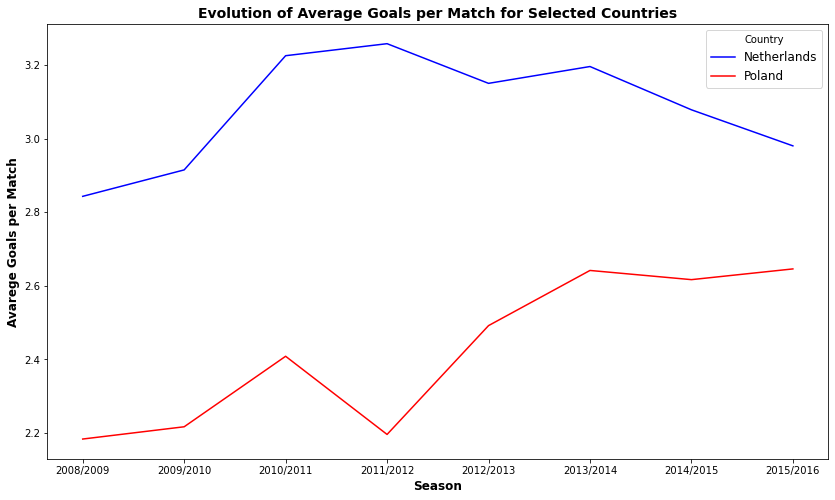

In [43]:
#Plotting the evolution of average goals for the Netherlands and Poland
plt.figure(figsize=(14, 8))
plt.plot(netherlands_goals_season, label='Netherlands', color='blue')
plt.plot(poland_goals_season, label='Poland', color='red')
plt.legend(title='Country', fontsize=12)
plt.ylabel('Avarege Goals per Match', fontsize=12, weight='bold')
plt.xlabel('Season', fontsize=12, weight='bold')
plt.title('Evolution of Average Goals per Match for Selected Countries', fontsize=14, weight='bold');

We can see that the Netherlands always had a greater average of goals per match than Poland. We can also see that since the 2011/2012 season, the Polish league had an increase on its avarege number of goals per match, reaching more than 2.6 goals per match in the 2015/2016 season.

### Is there a home team advantage? That's it, do teams that play at home win more games?

In [44]:
#Exploring the match_result DataFrame
match_result.head()

,country_name,league_name,season,date,home_team_goal,away_team_goal,winner_team_api_id,match_result
0,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,1,1,NaN,Draw
1,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,0,0,NaN,Draw
2,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,0,3,8635.0,Away Team Win
3,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,5,0,9991.0,Home Team Win
4,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,1,3,9985.0,Away Team Win


In [45]:
#Count of results
match_result['match_result'].value_counts()

Home Team Win    11917
Away Team Win     7466
Draw              6596
Name: match_result, dtype: int64

In [46]:
#Percentage of each result
percentage_results = match_result['match_result'].value_counts()/len(match_result)
percentage_results

Home Team Win    0.458717
Away Team Win    0.287386
Draw             0.253897
Name: match_result, dtype: float64

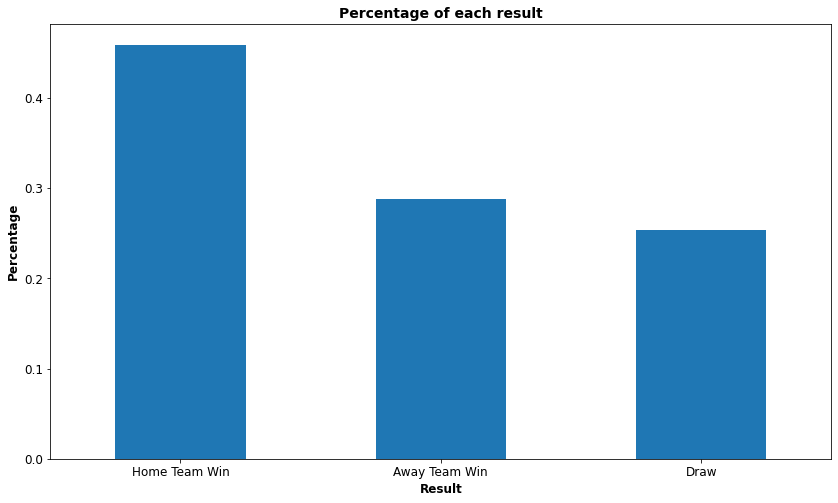

In [47]:
#Plotting the percentages
percentage_results.plot(kind='bar', figsize=(14, 8), rot=0, fontsize=12)
plt.title('Percentage of each result', fontsize=14, weight='bold')
plt.xlabel('Result', fontsize=12, weight='bold')
plt.ylabel('Percentage', fontsize=12, weight='bold');

We can see that there is a home team advantage as the Home Team wins 46% of the matches, while the Away Team only wins 29% of the matches.

In [48]:
#get home team wins 
home_team_wins = match_result.query('match_result == "Home Team Win"')
home_team_wins.head()

,country_name,league_name,season,date,home_team_goal,away_team_goal,winner_team_api_id,match_result
3,Belgium,Belgium Jupiler League,2008/2009,2008-08-17 00:00:00,5,0,9991.0,Home Team Win
8,Belgium,Belgium Jupiler League,2008/2009,2008-08-16 00:00:00,1,0,10001.0,Home Team Win
9,Belgium,Belgium Jupiler League,2008/2009,2008-11-01 00:00:00,4,1,8342.0,Home Team Win
21,Belgium,Belgium Jupiler League,2008/2009,2008-11-07 00:00:00,2,0,9984.0,Home Team Win
25,Belgium,Belgium Jupiler League,2008/2009,2008-11-08 00:00:00,1,0,10001.0,Home Team Win


In [49]:
home_team_wins_by_country = home_team_wins.groupby('country_name').count()['match_result']
home_team_wins_by_country

country_name
Belgium         810
England        1390
France         1359
Germany        1107
Italy          1407
Netherlands    1171
Poland          870
Portugal        908
Scotland        760
Spain          1485
Switzerland     650
Name: match_result, dtype: int64

In [50]:
#get total number of games per country
games_by_country = match_result.groupby('country_name').count()['league_name']
games_by_country

country_name
Belgium        1728
England        3040
France         3040
Germany        2448
Italy          3017
Netherlands    2448
Poland         1920
Portugal       2052
Scotland       1824
Spain          3040
Switzerland    1422
Name: league_name, dtype: int64

In [51]:
#proportion of each result per country
proportion_results_by_country = home_team_wins_by_country/games_by_country
proportion_results_by_country.sort_values()

country_name
Scotland       0.416667
Portugal       0.442495
France         0.447039
Germany        0.452206
Poland         0.453125
Switzerland    0.457103
England        0.457237
Italy          0.466357
Belgium        0.468750
Netherlands    0.478350
Spain          0.488487
dtype: float64

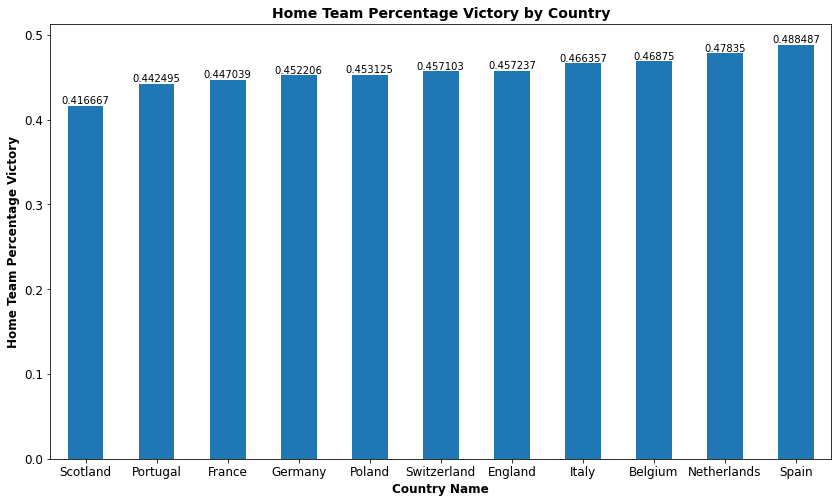

In [52]:
#visualization of home team wins by country
fig = proportion_results_by_country.sort_values().plot(kind='bar', figsize=(14, 8), rot=0, fontsize=12)
plt.title('Home Team Percentage Victory by Country', fontsize=14, weight='bold')
plt.xlabel('Country Name', fontsize=12, weight='bold')
plt.ylabel('Home Team Percentage Victory', fontsize=12, weight='bold')
fig.bar_label(fig.containers[0], label_type='edge');


Spain is the country with the highest home team advantage, 49% of the matches in the country had the home team as the winner. Meanwhile, Scotland was the country with the lowest home team advantage, only 42% of the matches had the home team as the winner. We can also see that the home team advatange exists in all countries, althought its magnitude can change a few percentage points for each country.

### Which players improved their overall rating the most during the period?

In [53]:
#Exploring the players df
df_players.head()

,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,player_name,height,weight,first_overall_rating,last_overall_rating
0,218353,505942,61.0,right,Aaron Appindangoye,182.88,187,61,67.0
1,189615,155782,53.0,right,Aaron Cresswell,170.18,146,53,74.0
2,186170,162549,59.0,right,Aaron Doran,170.18,163,59,65.0
3,140161,30572,71.0,right,Aaron Galindo,182.88,198,71,69.0
4,17725,23780,75.0,right,Aaron Hughes,182.88,154,75,70.0


In [54]:
#Creating overall improvement columns
df_players['overall_rating_improvement'] = df_players['last_overall_rating'] - df_players['first_overall_rating']

In [55]:
#Creating a function to plot histograms
def myHistPlot (df, xVar, interval, units=10, figsize=[14, 8]):
    '''
    This function will create a formatted histogram plot for a specific variable 
    '''
    
    #set the intervals for the bins
    #units use floor division to ensure intervals start at a rounded value
    bins=np.arange((df[xVar].min()//units)*units,df[xVar].max()+interval,interval)
    #plot
    df[xVar].hist(bins=bins,
                  grid=False,
                  edgecolor='black',
                  figsize=figsize);
    #for labels add a space instead of a underscore
    xVar = xVar.replace("_", " ")
    #Add title and format it
    plt.title(f'Distribution of {xVar}'.title(), fontsize=14, weight='bold')
    #Add xlabel and format it
    plt.xlabel(xVar.title(), fontsize=12, weight='bold')
    #Add ylabel and format it
    plt.ylabel('Frequency'.title(), fontsize=12, weight='bold')

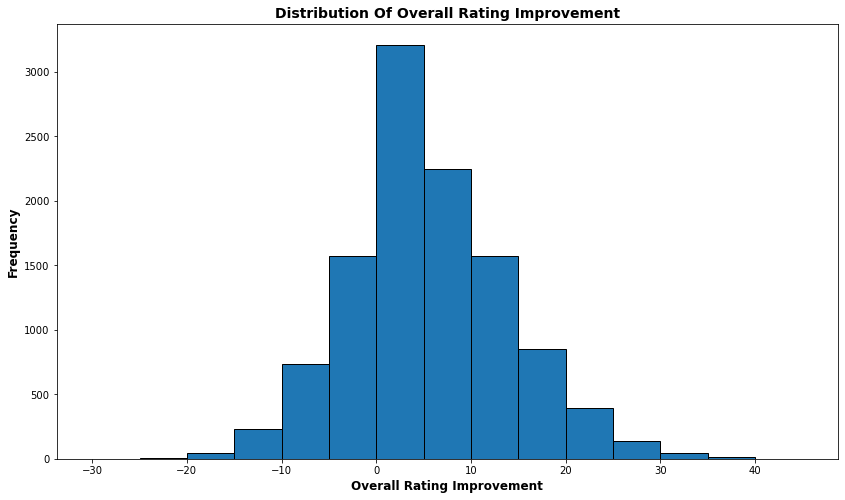

In [56]:
#Checking the improvement distribution using the new function
myHistPlot(df_players, 'overall_rating_improvement', 5)

In [57]:
#Summary statistics for the overall rating improvement column
df_players.overall_rating_improvement.describe()

count    11060.000000
mean         4.892767
std          8.369609
min        -25.000000
25%          0.000000
50%          4.000000
75%         10.000000
max         42.000000
Name: overall_rating_improvement, dtype: float64

In [58]:
#Finding the player with the greatest improvement
df_players[df_players['overall_rating_improvement'] == 42][['player_name','overall_rating_improvement']]

,player_name,overall_rating_improvement
6713,Marco Reus,42.0


Marco Reus was the player that improved the most during the period analyzed, his overall rating improved by 42 points. We'll also explore which were the top 10 players by overall rating improvement:

In [59]:
#Selecting the 10 players that improved the most
df_players[['player_name','overall_rating_improvement']].sort_values('overall_rating_improvement', ascending=False).head(10)

,player_name,overall_rating_improvement
6713,Marco Reus,42.0
8189,Oscar de Marcos,37.0
8694,Radja Nainggolan,37.0
2833,Eden Hazard,37.0
8918,Ricardo Rodriguez,37.0
1083,Bakary Sako,37.0
5954,Lamine Kone,36.0
3458,Francesco Della Rocca,36.0
6086,Leonardo Bonucci,36.0
3903,Glenn Murray,36.0


### Is there a correlation between a player's height and his overall rating?

Text(0, 0.5, 'Overall Rating')

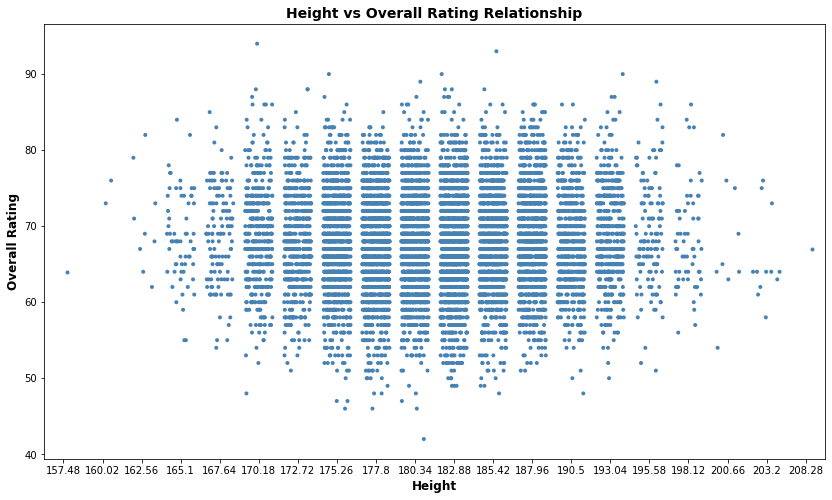

In [60]:
#Set plot dimension
plt.figure(figsize=[14, 8])

#Ploting the scatter plot of height and overall rating
sns.stripplot(data=df_players, x='height', y='last_overall_rating', jitter=0.35, color='steelblue', size=4)
plt.title('Height vs Overall Rating Relationship', fontsize=14, weight='bold')
plt.xlabel('Height', fontsize=12, weight='bold')
plt.ylabel('Overall Rating', fontsize=12, weight='bold')

In [61]:
#Calculation the correlation between the player's height and his overall rating
df_players['height'].corr(df_players['last_overall_rating'])

0.014232305943372365

Looking at the scatter plot graph it doesn't look like there is any clear relationship between the player's height and his overall rating.
Calculation the correlation between these two variables confirms that there is no strong correlation betweem them, as the correlation was smaller thant 0.02

### Do players with a specific preferred foot have a higher overall rating?

In [62]:
#Create data frame only with left foot preferred players
left_foot_players = df_players.query('preferred_foot == "left"')
left_foot_players.head()

,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,player_name,height,weight,first_overall_rating,last_overall_rating,overall_rating_improvement
5,158138,27316,73.0,left,Aaron Hunt,182.88,161,73,77.0,4.0
13,183853,40719,59.0,left,Aaron Niguez,170.18,143,59,70.0,11.0
15,226014,597948,55.0,left,Aaron Splaine,172.72,163,55,55.0,0.0
16,213569,161644,62.0,left,Aaron Taylor-Sinclair,182.88,176,62,64.0,2.0
21,202425,245653,64.0,left,Abdelfettah Boukhriss,185.42,161,64,64.0,0.0


In [63]:
#Create data frame only with right foot preferred players
right_foot_players = df_players.query('preferred_foot == "right"')
right_foot_players.head()

,player_fifa_api_id,player_api_id,overall_rating,preferred_foot,player_name,height,weight,first_overall_rating,last_overall_rating,overall_rating_improvement
0,218353,505942,61.0,right,Aaron Appindangoye,182.88,187,61,67.0,6.0
1,189615,155782,53.0,right,Aaron Cresswell,170.18,146,53,74.0,21.0
2,186170,162549,59.0,right,Aaron Doran,170.18,163,59,65.0,6.0
3,140161,30572,71.0,right,Aaron Galindo,182.88,198,71,69.0,-2.0
4,17725,23780,75.0,right,Aaron Hughes,182.88,154,75,70.0,-5.0


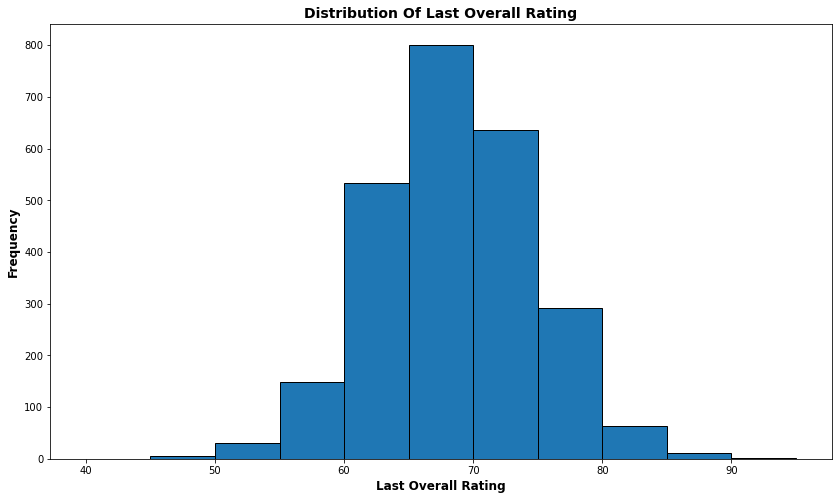

In [64]:
#Plot the histogram of overall rating for left foot preferred players
myHistPlot(left_foot_players, 'last_overall_rating', 5)

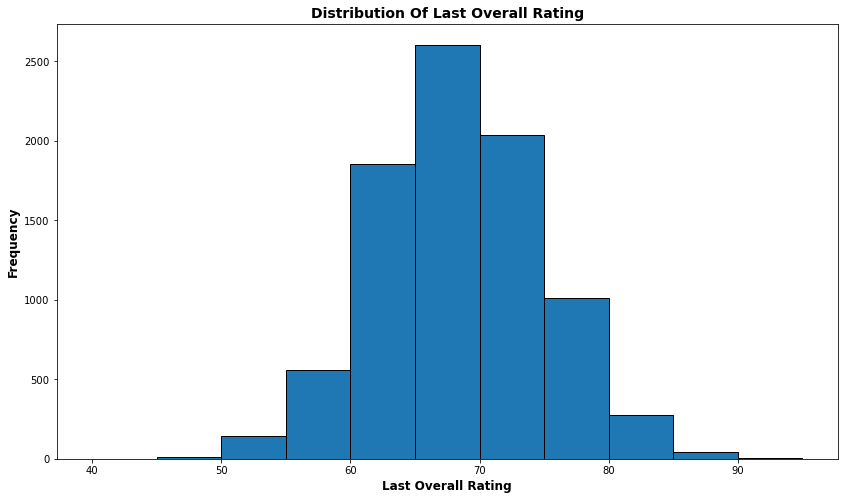

In [65]:
#Plot the histogram of overall rating for right foot preferred players
myHistPlot(right_foot_players, 'last_overall_rating', 5)

In [66]:
#Summary statistics for left footed players overall rating
left_foot_players.last_overall_rating.describe()

count    2522.000000
mean       68.053529
std         6.163313
min        46.000000
25%        64.000000
50%        68.000000
75%        72.000000
max        94.000000
Name: last_overall_rating, dtype: float64

In [67]:
#Summary statistics for right footed players overall rating
right_foot_players.last_overall_rating.describe()

count    8538.000000
mean       67.938862
std         6.363589
min        42.000000
25%        64.000000
50%        68.000000
75%        72.000000
max        93.000000
Name: last_overall_rating, dtype: float64

In [68]:
left_foot_players.last_overall_rating.mean()

68.05352894528153

In [69]:
right_foot_players.last_overall_rating.mean()

67.93886156008433

Left footed players mean overall rating (68.05) is a little bit higher than right footed players mean overall rating (67.94), but the difference is very small. When we look at the quantiles distribution it is the same for both foot, 25% quantile's overall rating is 64, the median is 68 and the 75% quantile is 72. Therefore, we can conclude that there is no relationship between the player's prefered foot and his overall rating.

### Which team attributes are associated with more victories?

In [70]:
#Take a look at the team wins and attributes data frame
df_team_wins_and_attributes.head()

,winner_team_api_id,team_long_name,league_name,season,wins_by_season,team_api_id,avg_speed,avg_passing,avg_creation_passing,avg_creation_crossing,avg_creation_shooting,avg_defence_pressure,avg_defence_aggression
0,1601,Ruch Chorzów,Poland Ekstraklasa,2009/2010,16,1601,30.0,40.0,50.0,35.0,70.0,65.0,60.0
1,1601,Ruch Chorzów,Poland Ekstraklasa,2010/2011,10,1601,48.0,51.0,68.0,67.0,51.0,46.0,48.0
2,1601,Ruch Chorzów,Poland Ekstraklasa,2011/2012,16,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0
3,1601,Ruch Chorzów,Poland Ekstraklasa,2013/2014,14,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0
4,1601,Ruch Chorzów,Poland Ekstraklasa,2014/2015,8,1601,53.0,38.0,66.0,65.0,50.0,43.0,44.0


In [71]:
#Explore some descriptive statistics
df_team_wins_and_attributes.describe()

,winner_team_api_id,wins_by_season,team_api_id,avg_speed,avg_passing,avg_creation_passing,avg_creation_crossing,avg_creation_shooting,avg_defence_pressure,avg_defence_aggression
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,9233.273543,13.199552,9233.273543,52.172646,47.788117,52.493274,54.001121,55.124439,46.626682,49.655830
std,6201.776211,5.635035,6201.776211,12.414801,11.357518,10.584541,11.407314,10.191829,10.682054,10.366642
min,1601.000000,1.000000,1601.000000,20.000000,22.000000,21.000000,20.000000,30.000000,23.000000,24.000000
25%,8481.000000,9.000000,8481.000000,45.000000,39.000000,46.750000,47.000000,50.000000,39.000000,44.000000
50%,8721.000000,12.000000,8721.000000,52.000000,48.000000,52.000000,53.500000,54.000000,46.000000,49.000000
75%,9927.000000,16.000000,9927.000000,63.000000,55.000000,60.000000,63.000000,64.000000,54.000000,57.000000
max,158085.000000,33.000000,158085.000000,78.000000,80.000000,80.000000,80.000000,80.000000,70.000000,70.000000


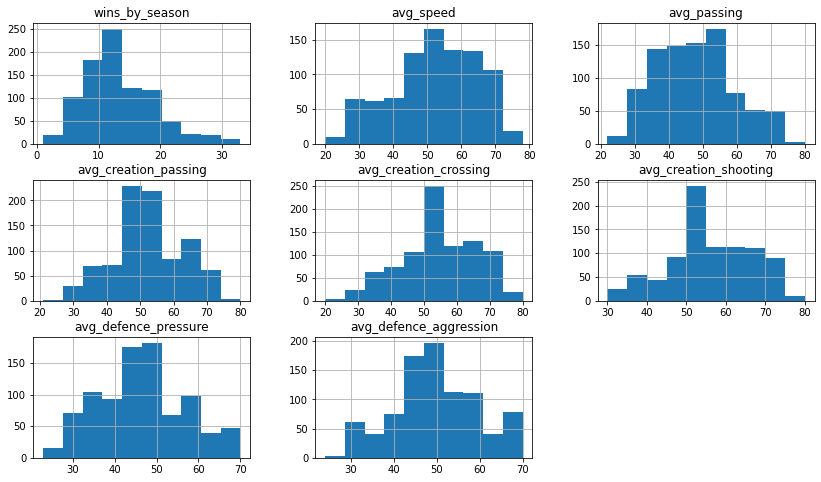

In [72]:
#Plot histograms for the continuos variables
df_team_wins_and_attributes.drop(['winner_team_api_id', 'team_api_id'], axis=1).hist(figsize=(14,8));

Based on the histograms we'll explore if the average speed and average creation shooting impact on the number of wins a team has.

In [73]:
# View the min, 25%, 50%, 75%, max avg speed
df_team_wins_and_attributes.avg_speed.describe()

count    892.000000
mean      52.172646
std       12.414801
min       20.000000
25%       45.000000
50%       52.000000
75%       63.000000
max       78.000000
Name: avg_speed, dtype: float64

In [74]:
#Get values for bins to cut the group
bin_edges = df_team_wins_and_attributes.avg_speed.describe().loc[['min', '25%', '50%', '75%', 'max']].values
bin_edges

array([20., 45., 52., 63., 78.])

In [75]:
#Label the bins
bin_names = ['Low Speed', 'Medium Speed', 'Medium High Speed', 'High Speed']

In [76]:
#Create speed level column
df_team_wins_and_attributes['speed_level'] = pd.cut(df_team_wins_and_attributes['avg_speed'], bin_edges, labels=bin_names)
#Check the dataframe
df_team_wins_and_attributes.head()

,winner_team_api_id,team_long_name,league_name,season,wins_by_season,team_api_id,avg_speed,avg_passing,avg_creation_passing,avg_creation_crossing,avg_creation_shooting,avg_defence_pressure,avg_defence_aggression,speed_level
0,1601,Ruch Chorzów,Poland Ekstraklasa,2009/2010,16,1601,30.0,40.0,50.0,35.0,70.0,65.0,60.0,Low Speed
1,1601,Ruch Chorzów,Poland Ekstraklasa,2010/2011,10,1601,48.0,51.0,68.0,67.0,51.0,46.0,48.0,Medium Speed
2,1601,Ruch Chorzów,Poland Ekstraklasa,2011/2012,16,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0,Medium High Speed
3,1601,Ruch Chorzów,Poland Ekstraklasa,2013/2014,14,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0,Medium High Speed
4,1601,Ruch Chorzów,Poland Ekstraklasa,2014/2015,8,1601,53.0,38.0,66.0,65.0,50.0,43.0,44.0,Medium High Speed


In [77]:
#Explore the average wins by season per speed level
df_team_wins_and_attributes.groupby('speed_level')['wins_by_season'].mean()

speed_level
Low Speed            13.366935
Medium Speed         12.995025
Medium High Speed    12.851528
High Speed           13.578199
Name: wins_by_season, dtype: float64

It doesn't look like having a high average speeds leads to more wins by season, as teams with low speed levels have more average wins than teams with medium high speed levels.

In [78]:
# View the min, 25%, 50%, 75%, max for avg shooting creation
df_team_wins_and_attributes.avg_creation_shooting.describe()

count    892.000000
mean      55.124439
std       10.191829
min       30.000000
25%       50.000000
50%       54.000000
75%       64.000000
max       80.000000
Name: avg_creation_shooting, dtype: float64

In [79]:
#Get values for bins to cut the group
bin_edges = df_team_wins_and_attributes.avg_creation_shooting.describe().loc[['min', '25%', '50%', '75%', 'max']].values
bin_edges

array([30., 50., 54., 64., 80.])

In [80]:
#Label the bins
bin_names = ['Low Shooting', 'Medium Shooting', 'Medium High Shooting', 'High Shooting']

In [81]:
#Create shooting level column
df_team_wins_and_attributes['shooting_level'] = pd.cut(df_team_wins_and_attributes['avg_creation_shooting'], bin_edges, labels=bin_names)
#Check the dataframe
df_team_wins_and_attributes.head()

,winner_team_api_id,team_long_name,league_name,season,wins_by_season,team_api_id,avg_speed,avg_passing,avg_creation_passing,avg_creation_crossing,avg_creation_shooting,avg_defence_pressure,avg_defence_aggression,speed_level,shooting_level
0,1601,Ruch Chorzów,Poland Ekstraklasa,2009/2010,16,1601,30.0,40.0,50.0,35.0,70.0,65.0,60.0,Low Speed,High Shooting
1,1601,Ruch Chorzów,Poland Ekstraklasa,2010/2011,10,1601,48.0,51.0,68.0,67.0,51.0,46.0,48.0,Medium Speed,Medium Shooting
2,1601,Ruch Chorzów,Poland Ekstraklasa,2011/2012,16,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0,Medium High Speed,Low Shooting
3,1601,Ruch Chorzów,Poland Ekstraklasa,2013/2014,14,1601,53.0,55.0,44.0,65.0,50.0,43.0,44.0,Medium High Speed,Low Shooting
4,1601,Ruch Chorzów,Poland Ekstraklasa,2014/2015,8,1601,53.0,38.0,66.0,65.0,50.0,43.0,44.0,Medium High Speed,Low Shooting


In [82]:
#Explore the average wins by season per shooting level
df_team_wins_and_attributes.groupby('shooting_level')['wins_by_season'].mean()

shooting_level
Low Shooting            12.525253
Medium Shooting         12.889610
Medium High Shooting    12.890351
High Shooting           14.660287
Name: wins_by_season, dtype: float64

It looks like teams with a higher shooting creation levels have an average of more wins by season, as teams with High Shooting level have the highest average wins by season and teams with a Low Shooting level have the lowest rate of wins.

<a id='conclusions'></a>
## Conclusions

In this project we analyzed some descriptive statistics from the Soccer Dataset and reached some interesting conclusions, such as that the winner of most games is usually the home team, that there is no clear relationship between a player's height and his overall rating. We also concluded that the preffered foot doesn't seem to impact a player's rating and that teams with a higher shooting creation level tend to win more games in a season. We also discovered which players improved the most points in their ratings during the period and which country's league has the highest average number of goals per match.
In this data analysis we didn't conduct any causal inferation analysis, therefore the results shouldn't be seen as causal relationships. For future analysis it would be interesting to conduct some statistical tests and causal inferation to see what are the causal links between the data. Another limitation of this analysis is that it only includes data from players and match from some European Soccer Leagues from 2008 to 2016, it would be interesting to explore if the results are the same for other periods and locations. Furthermore, in this analysis we didn't conduct any statistical inference analysis to test the significance of the results.